# Traffic Sign Recognition with Tensorflow - SHARE

# Objective: Traffic Sign Classification and Robustness analysis

 Given an image of a traffic sign, our model should be able to tell it's type (e.g. Stop sign, speed limit, yield sign, ...etc.). We'll work with images that are properly cropped such that the traffic sign takes most of the image.

Then, we (you) need to create altered images and submit them to the trained model

FROM: Kaggle

https://www.kaggle.com/sanikamal/traffic-sign-recognition-with-tensorflow

and

https://www.pyimagesearch.com/2019/11/04/traffic-sign-classification-with-keras-and-deep-learning/

with several changes

## Let's import the needed libraries and data

In [ ]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.misc
#import PIL
import matplotlib
import matplotlib.pyplot as plt
import skimage.data
import skimage.transform
import tensorflow as tf
import random
import os
from skimage import io
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
from keras.callbacks import ModelCheckpoint, EarlyStopping



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = '/content/gdrive/My Drive/DCML_CPS_2024'
#change dir to your project folder, ColabDCML in my case

Mounted at /content/gdrive


We set the data path

In [ ]:
data_root=root_path+'/Datasets/TrafficSigndataset/'
train_data_dir=data_root+'/Training'
test_data_dir=data_root+'/Testing'

# Parse and Load the Training Data

The Training directory contains sub-directories with sequental numerical names from 00000 to 00061. The name of the directory represents the labels from 0 to 61, and the images in each directory represent the traffic signs that belong to that label.

In [ ]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        print(d)
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load its images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(io.imread(f))
            labels.append(int(d))
    return images, labels



Here we're loading two lists:

* images a list of images, each image is represted by a numpy array.
* labels a list of labels. Integers with values between 0 and 61.

TAKES QUITE SOME TIME!!!

In [ ]:
#THIS TAKES QUITE SOME TIME!!!
# Load training datasets.
images, labels = load_data(train_data_dir)

00007
00001
00009
00003
00000
00004
00005
00008
00006
00002
00018
00010
00019
00015
00013
00017
00011
00016
00014
00012
00027
00029
00022
00026
00021
00023
00028
00025
00024
00020
00038
00037
00031
00039
00030
00032
00034
00036
00035
00033
00047
00041
00049
00045
00044
00043
00042
00046
00048
00040
00052
00055
00050
00053
00058
00057
00056
00054
00059
00051
00061
00060


## Explore the Dataset


In [ ]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575




Display the first image of each label.


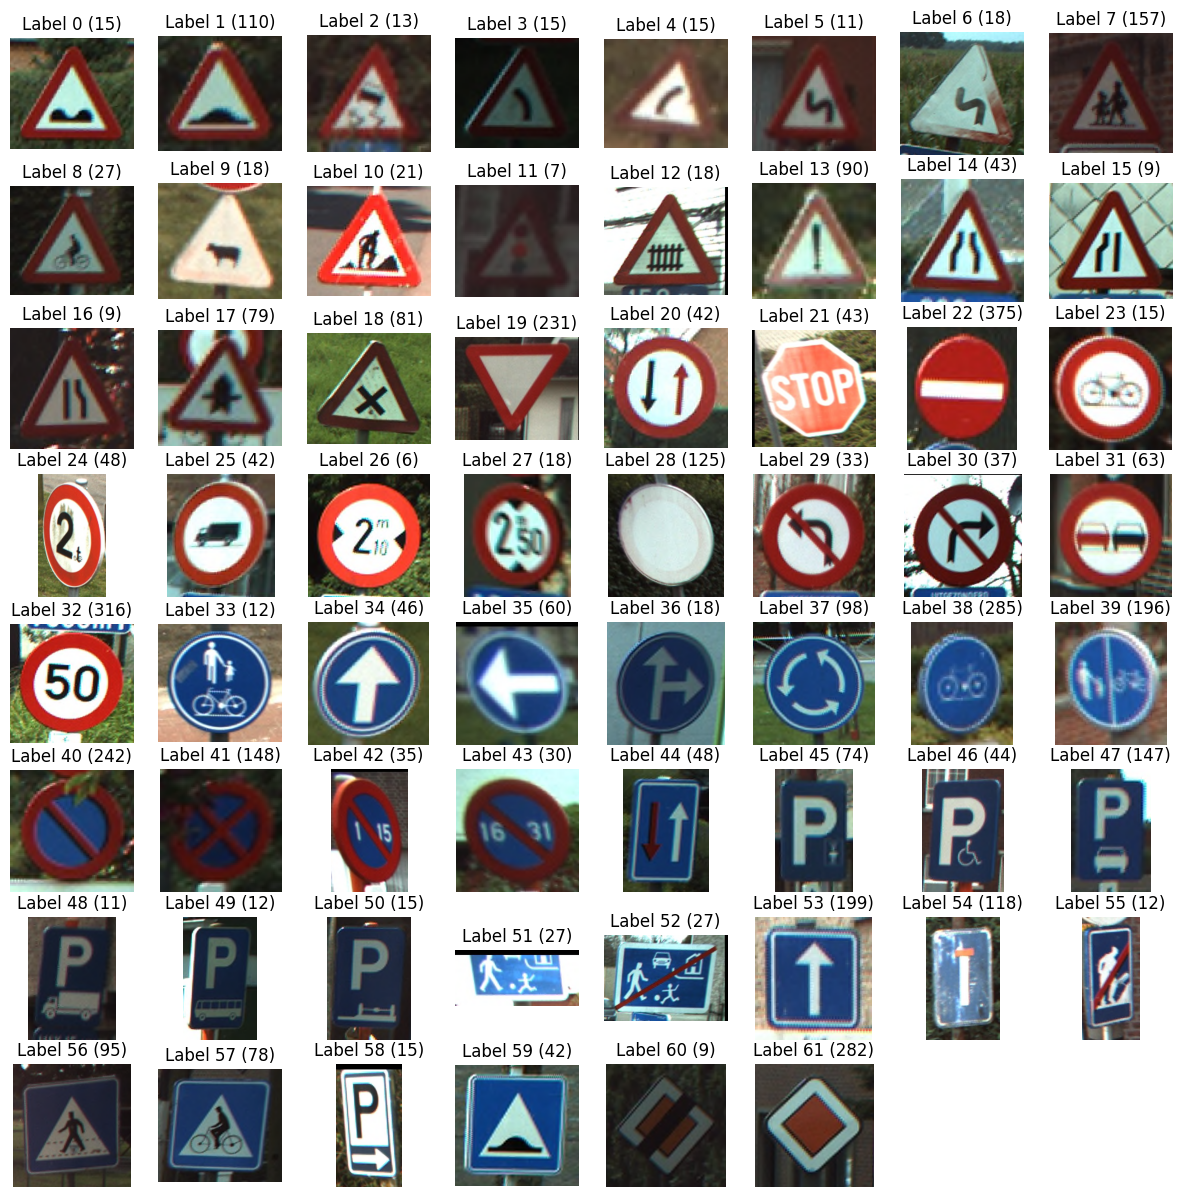

In [ ]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)



That looks great! The traffic signs occupy most of the area of each image, which is going to make our job easier: we don't have to look for the sign in the image. And we have a variety of angles and lighting conditions, which will help our model generalize.

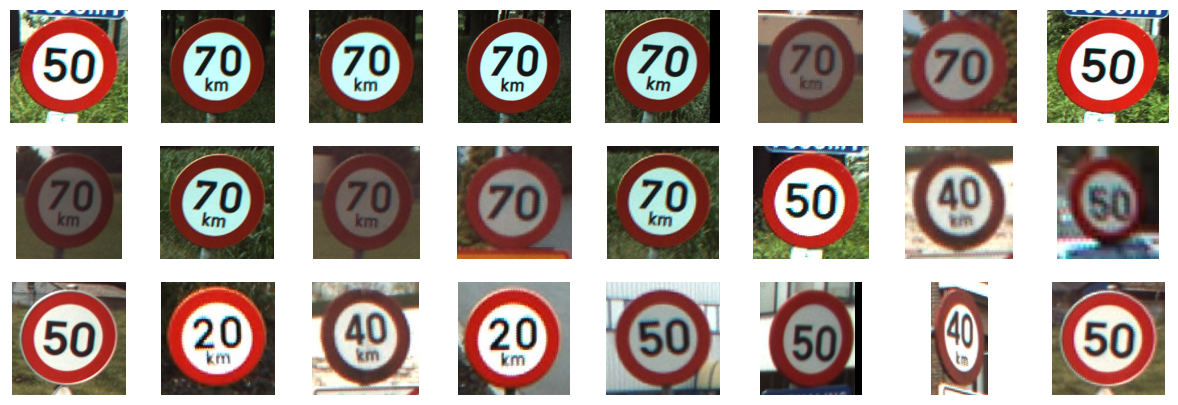

In [ ]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels.index(label)
    end = start + labels.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images, 32) # you can change this number

## Handling images of different sizes?

Most neural networks expect a fixed-size input, and our network is no exception. But as we've seen above, our images are not all the same size.

We'll just resize the images to a fixed size and ignore the distortions caused by the different aspect ratios. A person can easily recognize a traffic sign even if it's compressed or stretched a bit, so we hope that our model can as well.

In [ ]:
for image in images[:5]: #see that images are of different size
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (95, 98, 3), min: 11, max: 137
shape: (69, 74, 3), min: 0, max: 90
shape: (99, 121, 3), min: 0, max: 255
shape: (109, 112, 3), min: 13, max: 149
shape: (153, 179, 3), min: 0, max: 255




We resize to 32x32 which is  still big enough to recognize the signs.

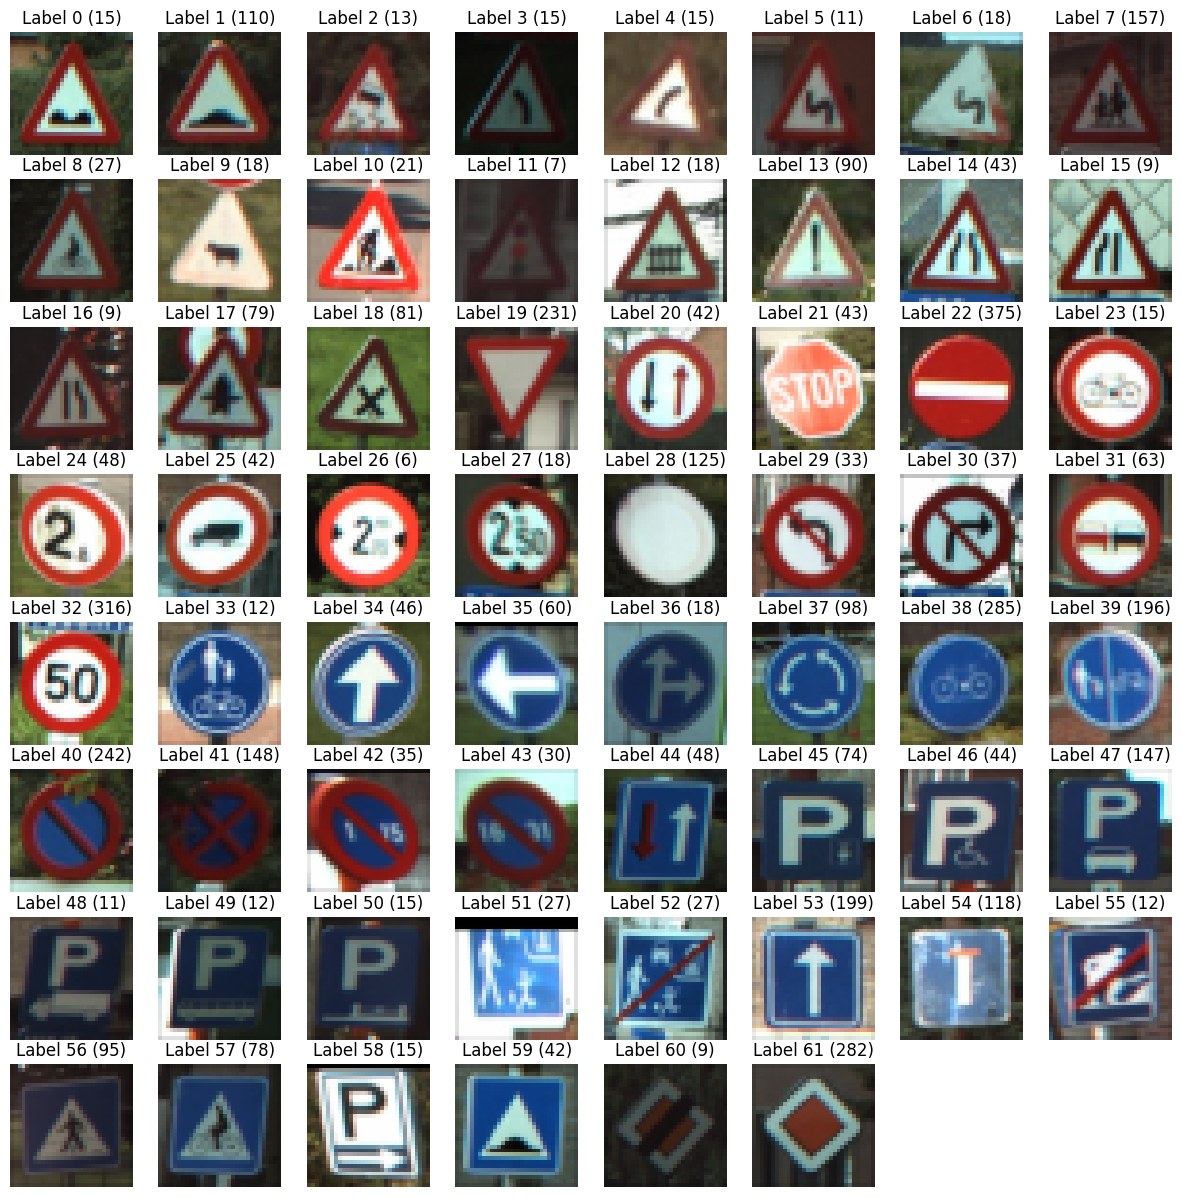

In [ ]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32), mode='constant')
                for image in images]
display_images_and_labels(images32, labels)

In [ ]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.06102462090149756, max: 0.4262752800382169
shape: (32, 32, 3), min: 0.014504148736885904, max: 0.33887150868798227
shape: (32, 32, 3), min: 0.06966758975777679, max: 0.9953876393252452
shape: (32, 32, 3), min: 0.06587326749881929, max: 0.5016023242713755
shape: (32, 32, 3), min: 0.058221689667487204, max: 0.8413142110796225




The sizes are correct. But check the min and max values! They now range from 0 to 1.0, which is different from the 0-255 range we saw above. The resizing function did that transformation for us. Normalizing values to the range 0.0-1.0 is very common so we'll keep it. But remember to multiply by 255 if you later want to convert the images back to the normal 0-255 range.


# Simple Model

first we convert everything to numpy arrays

In [ ]:
train_labels = np.array(labels)
train_images = np.array(images32)
print("labels: ", train_labels.shape, "\nimages: ", train_images.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)


In [ ]:
class TrafficSignNet:

	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (32, 32, 3)
		chanDim = -1
		# CONV => RELU => BN => POOL
		model.add(Conv2D(8, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# first set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# second set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model

add data augmentation and set loss, optimizer

In [ ]:
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
  validation_split=0.2,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

# initialize the optimizer and compile the model
print("[INFO] compiling model...")
INIT_LR=0.001
NUM_EPOCHS=100
numLabels=62
BS=128
# Replace 'lr' with 'learning_rate' and remove the 'decay' argument
opt = Adam(learning_rate=INIT_LR, weight_decay=INIT_LR / (NUM_EPOCHS * 0.5))

# Rest of your model code...
model = TrafficSignNet.build(width=32, height=32, depth=3, classes=numLabels)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │              

 Total params: 109,598 (428.12 KB)

 Trainable params: 108,878 (425.30 KB)

 Non-trainable params: 720 (2.81 KB)

add callbacks

In [ ]:
cb=EarlyStopping(monitor='loss', mode='min', patience=3) # to stop after 3 times loss does not improve

checkpoint_path = root_path+"/TSC/checkpoint.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_freq="epoch", #every epoch we save checkpoints
                                                 save_weights_only=True, verbose=1)

cb_list = [cb, cp_callback]

And finally we train the model!!!

In [ ]:
print("[INFO] training network...")
H = model.fit(aug.flow(train_images, train_labels, shuffle=True, batch_size=BS), shuffle=True, epochs=NUM_EPOCHS, callbacks=cb_list) #, validation_split = 0.2)


[INFO] training network...
Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7325 - loss: 0.8979
Epoch 1: saving model to /content/gdrive/My Drive/DCML_CPS_2024/TSC/checkpoint.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.7329 - loss: 0.8972
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7657 - loss: 0.8139
Epoch 2: saving model to /content/gdrive/My Drive/DCML_CPS_2024/TSC/checkpoint.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 308ms/step - accuracy: 0.7655 - loss: 0.8138
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7747 - loss: 0.7610
Epoch 3: saving model to /content/gdrive/My Drive/DCML_CPS_2024/TSC/checkpoint.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 236ms/step - accuracy: 0.7746 - loss: 0.7615
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.7871 - loss: 0.7301
Epoch 4: saving model to /content/gdrive/My Drive/DCML_CPS_2024/TSC/checkpoint.weights.h5
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 270ms/s


# Testing
We now can perform tests

First we load the test set

In [ ]:
t_images, t_labels = load_data(test_data_dir)
# Transform the images, just like we did with the training set.
test_images = [skimage.transform.resize(image, (32, 32), mode='constant')
                 for image in t_images]
#display_images_and_labels(test_images32, test_labels)

test_labels = np.array(t_labels)
test_images = np.array(test_images)

00055
00059
00060
00054
00057
00056
00061
00053
00052
00058
00047
00045
00043
00051
00050
00042
00046
00048
00049
00044
00037
00041
00039
00038
00040
00034
00036
00032
00033
00035
00029
00027
00023
00024
00031
00022
00025
00028
00026
00030
00012
00016
00014
00020
00019
00013
00018
00021
00015
00017
00010
00007
00002
00004
00009
00003
00005
00006
00011
00008
00001
00000


In [ ]:
loss, acc = model.evaluate(test_images, test_labels, verbose=2)

5/5 - 1s - 127ms/step - accuracy: 0.9549 - loss: 0.0836
